In [1]:
import numpy as np
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
import os

logdir = os.path.join("callbacks")

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# load dataset
dataset = pd.read_csv('CER_data_clean.csv', header=0, index_col=0)
dataset = dataset.loc[:, ['Power', 'holidays', 'Hour', 'Days', 'Month', 'Temperature', 'humiduity', 'Wind_speed']]
print(dataset.head())
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

     Power  holidays  Hour  Days  Month  Temperature  humiduity  Wind_speed
0  322.546         0   0.0    14      7         11.8       93.0        14.4
1  279.998         0   0.5    14      7         11.8       91.0        14.4
2  245.900         0   1.0    14      7         11.8       89.0        18.0
3  219.626         0   1.5    14      7         11.6       91.0        18.0
4  204.403         0   2.0    14      7         11.4       93.0        10.8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.169508        0.0   0.000000   0.433333   0.545455   0.673469   
2   0.122673        0.0   0.021277   0.433333   0.545455   0.673469   
3   0.085139        0.0   0.042553   0.433333   0.545455   0.673469   
4   0.056218        0.0   0.063830   0.433333   0.545455   0.667639   
5   0.039461        0.0   0.085106   0.433333   0.545455   0.661808   

   var7(t-1)  var8(t-1)   var1(t)  
1       0.93   0.166667  0.122673  
2       0.91   0.166667  0.085139  
3       0

In [10]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=1e-1, input_shape=(train_X.shape[1], train_X.shape[2])):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs= {
    "n_hidden": np.arange(1, 10).tolist(),
    "n_neurons": np.arange(1, 300).tolist(),
    "learning_rate": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
}

checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_New_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(train_X, train_y, epochs=50, validation_split=0.1, shuffle=True, batch_size=32,
                  callbacks=[checkpoint_cb, early_stopping_cb])


print(rnd_search_cv.best_params_)
print('score:', rnd_search_cv.best_score_)

Epoch 1/50
572/572 [==============================] - 19s 19ms/step - loss: 0.3332 - mape: 99.9700 - val_loss: 0.4464 - val_mape: 99.9351
Epoch 2/50
572/572 [==============================] - 10s 18ms/step - loss: 0.3319 - mape: 99.8497 - val_loss: 0.4462 - val_mape: 99.8703
Epoch 3/50
572/572 [==============================] - 10s 17ms/step - loss: 0.3323 - mape: 99.7330 - val_loss: 0.4460 - val_mape: 99.8053
Epoch 4/50
572/572 [==============================] - 10s 18ms/step - loss: 0.3312 - mape: 99.6084 - val_loss: 0.4458 - val_mape: 99.7400
Epoch 5/50
572/572 [==============================] - 10s 17ms/step - loss: 0.3334 - mape: 99.4860 - val_loss: 0.4456 - val_mape: 99.6745
Epoch 6/50
572/572 [==============================] - 10s 17ms/step - loss: 0.3342 - mape: 99.3642 - val_loss: 0.4454 - val_mape: 99.6088
Epoch 7/50
572/572 [==============================] - 10s 17ms/step - loss: 0.3350 - mape: 99.2563 - val_loss: 0.4452 - val_mape: 99.5429
Epoch 8/50
572/572 [==============

572/572 [==============================] - 15s 26ms/step - loss: 0.3180 - mape: 464.7235 - val_loss: 0.4431 - val_mape: 98.8486
Epoch 18/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3135 - mape: 156.0604 - val_loss: 0.4428 - val_mape: 98.7789
Epoch 19/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3182 - mape: 639.4587 - val_loss: 0.4426 - val_mape: 98.7089
Epoch 20/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3135 - mape: 213.8564 - val_loss: 0.4424 - val_mape: 98.6388
Epoch 21/50
572/572 [==============================] - 15s 27ms/step - loss: 0.3156 - mape: 318.2111 - val_loss: 0.4422 - val_mape: 98.5684
Epoch 22/50
572/572 [==============================] - 16s 28ms/step - loss: 0.3154 - mape: 119.8227 - val_loss: 0.4420 - val_mape: 98.4978
Epoch 23/50
572/572 [==============================] - 15s 27ms/step - loss: 0.3150 - mape: 121.6311 - val_loss: 0.4418 - val_mape: 98.4270
Epoch 24/50
572/572 [===========

572/572 [==============================] - 19s 34ms/step - loss: 0.3355 - mape: 374.2591 - val_loss: 0.4410 - val_mape: 98.1765
Epoch 26/50
572/572 [==============================] - 20s 35ms/step - loss: 0.3359 - mape: 356.3989 - val_loss: 0.4408 - val_mape: 98.1003
Epoch 27/50
572/572 [==============================] - 20s 34ms/step - loss: 0.3374 - mape: 876.1905 - val_loss: 0.4406 - val_mape: 98.0237
Epoch 28/50
572/572 [==============================] - 19s 34ms/step - loss: 0.3349 - mape: 599.9157 - val_loss: 0.4403 - val_mape: 97.9469
Epoch 29/50
572/572 [==============================] - 19s 34ms/step - loss: 0.3348 - mape: 213.1296 - val_loss: 0.4401 - val_mape: 97.8699
Epoch 30/50
572/572 [==============================] - 19s 32ms/step - loss: 0.3361 - mape: 262.9387 - val_loss: 0.4398 - val_mape: 97.7926
Epoch 31/50
572/572 [==============================] - 18s 31ms/step - loss: 0.3345 - mape: 288.3338 - val_loss: 0.4396 - val_mape: 97.7150
Epoch 32/50
572/572 [===========

572/572 [==============================] - 15s 27ms/step - loss: 0.3269 - mape: 306.2085 - val_loss: 0.2547 - val_mape: 94.7707
Epoch 34/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3271 - mape: 200.3727 - val_loss: 0.2545 - val_mape: 94.6033
Epoch 35/50
572/572 [==============================] - 16s 27ms/step - loss: 0.3252 - mape: 167.1734 - val_loss: 0.2543 - val_mape: 94.4352
Epoch 36/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3230 - mape: 331.2724 - val_loss: 0.2541 - val_mape: 94.2667
Epoch 37/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3240 - mape: 194.9207 - val_loss: 0.2539 - val_mape: 94.0977
Epoch 38/50
572/572 [==============================] - 19s 33ms/step - loss: 0.3264 - mape: 1202.3792 - val_loss: 0.2537 - val_mape: 93.9281
Epoch 39/50
572/572 [==============================] - 19s 33ms/step - loss: 0.3254 - mape: 642.1218 - val_loss: 0.2534 - val_mape: 93.7578
Epoch 40/50
572/572 [==========

572/572 [==============================] - 22s 39ms/step - loss: 0.2810 - mape: 1011.5756 - val_loss: 0.4350 - val_mape: 96.2031
Epoch 50/50
159/159 [==============================] - 2s 13ms/step - loss: 0.4162 - mape: 95.5978
Epoch 1/50
572/572 [==============================] - 40s 44ms/step - loss: 0.3185 - mape: 103.3114 - val_loss: 0.4464 - val_mape: 99.9369
Epoch 2/50
572/572 [==============================] - 22s 39ms/step - loss: 0.3185 - mape: 130.0738 - val_loss: 0.4462 - val_mape: 99.8735
Epoch 3/50
572/572 [==============================] - 21s 37ms/step - loss: 0.3176 - mape: 134.1274 - val_loss: 0.4460 - val_mape: 99.8098
Epoch 4/50
572/572 [==============================] - 22s 38ms/step - loss: 0.3198 - mape: 168.2047 - val_loss: 0.4458 - val_mape: 99.7459
Epoch 5/50
572/572 [==============================] - 23s 40ms/step - loss: 0.3210 - mape: 123.2733 - val_loss: 0.4456 - val_mape: 99.6817
Epoch 6/50
572/572 [==============================] - 23s 40ms/step - loss: 0

572/572 [==============================] - 28s 49ms/step - loss: 0.3300 - mape: 293.9576 - val_loss: 0.2583 - val_mape: 97.7217
Epoch 15/50
572/572 [==============================] - 28s 49ms/step - loss: 0.3282 - mape: 273.7199 - val_loss: 0.2581 - val_mape: 97.5540
Epoch 16/50
572/572 [==============================] - 28s 49ms/step - loss: 0.3310 - mape: 280.6255 - val_loss: 0.2579 - val_mape: 97.3856
Epoch 17/50
572/572 [==============================] - 28s 50ms/step - loss: 0.3279 - mape: 248.7291 - val_loss: 0.2577 - val_mape: 97.2166
Epoch 18/50
572/572 [==============================] - 28s 49ms/step - loss: 0.3285 - mape: 226.0900 - val_loss: 0.2575 - val_mape: 97.0469
Epoch 19/50
572/572 [==============================] - 28s 48ms/step - loss: 0.3272 - mape: 484.7245 - val_loss: 0.2573 - val_mape: 96.8766
Epoch 20/50
572/572 [==============================] - 27s 47ms/step - loss: 0.3256 - mape: 236.6441 - val_loss: 0.2571 - val_mape: 96.7057
Epoch 21/50
572/572 [===========

572/572 [==============================] - 20s 35ms/step - loss: 0.2897 - mape: 302.6899 - val_loss: 0.4410 - val_mape: 98.1756
Epoch 31/50
572/572 [==============================] - 19s 34ms/step - loss: 0.2884 - mape: 213.3350 - val_loss: 0.4408 - val_mape: 98.1117
Epoch 32/50
572/572 [==============================] - 20s 35ms/step - loss: 0.2883 - mape: 180.8565 - val_loss: 0.4406 - val_mape: 98.0474
Epoch 33/50
572/572 [==============================] - 20s 36ms/step - loss: 0.2867 - mape: 187.2382 - val_loss: 0.4404 - val_mape: 97.9830
Epoch 34/50
572/572 [==============================] - 20s 35ms/step - loss: 0.2876 - mape: 402.7614 - val_loss: 0.4402 - val_mape: 97.9183
Epoch 35/50
572/572 [==============================] - 20s 35ms/step - loss: 0.2861 - mape: 126.5756 - val_loss: 0.4400 - val_mape: 97.8534
Epoch 36/50
572/572 [==============================] - 20s 35ms/step - loss: 0.2860 - mape: 1744.0074 - val_loss: 0.4398 - val_mape: 97.7883
Epoch 37/50
572/572 [==========

572/572 [==============================] - 15s 26ms/step - loss: 0.3134 - mape: 960.0578 - val_loss: 0.4386 - val_mape: 97.3662
Epoch 39/50
572/572 [==============================] - 15s 26ms/step - loss: 0.3133 - mape: 227.6130 - val_loss: 0.4383 - val_mape: 97.2923
Epoch 40/50
572/572 [==============================] - 15s 25ms/step - loss: 0.3142 - mape: 135.7034 - val_loss: 0.4381 - val_mape: 97.2182
Epoch 41/50
572/572 [==============================] - 14s 24ms/step - loss: 0.3113 - mape: 966.2819 - val_loss: 0.4379 - val_mape: 97.1439
Epoch 42/50
572/572 [==============================] - 14s 24ms/step - loss: 0.3096 - mape: 629.6638 - val_loss: 0.4377 - val_mape: 97.0693
Epoch 43/50
572/572 [==============================] - 14s 24ms/step - loss: 0.3104 - mape: 712.6563 - val_loss: 0.4374 - val_mape: 96.9944
Epoch 44/50
572/572 [==============================] - 14s 24ms/step - loss: 0.3106 - mape: 566.0280 - val_loss: 0.4372 - val_mape: 96.9193
Epoch 45/50
572/572 [===========

Epoch 4/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1486 - mape: 82.8152 - val_loss: 0.1769 - val_mape: 47.2476
Epoch 5/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1254 - mape: 99.4933 - val_loss: 0.1574 - val_mape: 45.9247
Epoch 6/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1186 - mape: 97.0031 - val_loss: 0.1483 - val_mape: 43.3302
Epoch 7/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1120 - mape: 96.1138 - val_loss: 0.1415 - val_mape: 40.1507
Epoch 8/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1062 - mape: 87.6307 - val_loss: 0.1347 - val_mape: 36.9553
Epoch 9/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0997 - mape: 78.5828 - val_loss: 0.1275 - val_mape: 33.7609
Epoch 10/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0932 - mape: 70.7441 - val_loss: 0.1217 - val_mape: 30.6032
Epoch 11/50
572/572 [==========================

Epoch 22/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0472 - mape: 7751.8241 - val_loss: 0.0523 - val_mape: 11.9059
Epoch 23/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0453 - mape: 79.5334 - val_loss: 0.0483 - val_mape: 11.1719
Epoch 24/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0441 - mape: 301.6681 - val_loss: 0.0460 - val_mape: 10.6087
Epoch 25/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0422 - mape: 4739.3367 - val_loss: 0.0434 - val_mape: 10.1271
Epoch 26/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0410 - mape: 367.5275 - val_loss: 0.0415 - val_mape: 9.7645
Epoch 27/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0403 - mape: 109.5172 - val_loss: 0.0397 - val_mape: 9.4901
Epoch 28/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0391 - mape: 619.1508 - val_loss: 0.0390 - val_mape: 9.1229
Epoch 29/50
572/572 [===============

Epoch 31/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0385 - mape: 509.0993 - val_loss: 0.0360 - val_mape: 8.5709
Epoch 32/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0381 - mape: 176.3459 - val_loss: 0.0356 - val_mape: 8.4081
Epoch 33/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0378 - mape: 1061.6993 - val_loss: 0.0352 - val_mape: 8.2261
Epoch 34/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0367 - mape: 757.3306 - val_loss: 0.0348 - val_mape: 8.2095
Epoch 35/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0365 - mape: 216.0637 - val_loss: 0.0346 - val_mape: 8.1091
Epoch 36/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0365 - mape: 4979.3774 - val_loss: 0.0340 - val_mape: 8.1107
Epoch 37/50
572/572 [==============================] - 2s 3ms/step - loss: 0.0359 - mape: 2083.1669 - val_loss: 0.0338 - val_mape: 8.0231
Epoch 38/50
572/572 [=================

Epoch 49/50
572/572 [==============================] - 4s 8ms/step - loss: 0.0226 - mape: 9.1509 - val_loss: 0.0241 - val_mape: 5.8332
Epoch 50/50
159/159 [==============================] - 0s 2ms/step - loss: 0.0180 - mape: 4128.1665
Epoch 1/50
572/572 [==============================] - 7s 8ms/step - loss: 0.1753 - mape: 8587.2289 - val_loss: 0.0964 - val_mape: 20.9999
Epoch 2/50
572/572 [==============================] - 4s 8ms/step - loss: 0.0487 - mape: 33.6484 - val_loss: 0.0406 - val_mape: 9.0994
Epoch 3/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0342 - mape: 8356.7928 - val_loss: 0.0379 - val_mape: 8.5061
Epoch 4/50
572/572 [==============================] - 3s 4ms/step - loss: 0.0305 - mape: 76.6153 - val_loss: 0.0350 - val_mape: 8.0466
Epoch 5/50
572/572 [==============================] - 3s 4ms/step - loss: 0.0281 - mape: 784.1596 - val_loss: 0.0304 - val_mape: 7.5048
Epoch 6/50
572/572 [==============================] - 2s 4ms/step - loss: 0.0275 - m

159/159 [==============================] - 0s 2ms/step - loss: 0.0160 - mape: 9.7425
Epoch 1/50
572/572 [==============================] - 5s 6ms/step - loss: 0.2002 - mape: 13299.9818 - val_loss: 0.0442 - val_mape: 30.7360
Epoch 2/50
572/572 [==============================] - 3s 6ms/step - loss: 0.0505 - mape: 243.2700 - val_loss: 0.0253 - val_mape: 15.6979
Epoch 3/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0371 - mape: 786.4986 - val_loss: 0.0222 - val_mape: 14.5726
Epoch 4/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0331 - mape: 157.3331 - val_loss: 0.0197 - val_mape: 10.8708
Epoch 5/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0315 - mape: 467.7267 - val_loss: 0.0183 - val_mape: 10.5851
Epoch 6/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0304 - mape: 899.2164 - val_loss: 0.0178 - val_mape: 10.3236
Epoch 7/50
572/572 [==============================] - 3s 5ms/step - loss: 0.0295 - mape: 13

572/572 [==============================] - 6s 11ms/step - loss: 0.2558 - mape: 1108.8939 - val_loss: 0.4053 - val_mape: 86.4321
Epoch 18/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2543 - mape: 1904.7944 - val_loss: 0.4020 - val_mape: 85.3345
Epoch 19/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2524 - mape: 876.6799 - val_loss: 0.3985 - val_mape: 84.1891
Epoch 20/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2502 - mape: 1046.3551 - val_loss: 0.3949 - val_mape: 82.9888
Epoch 21/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2439 - mape: 3304.8018 - val_loss: 0.3910 - val_mape: 81.7261
Epoch 22/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2435 - mape: 1429.0505 - val_loss: 0.3870 - val_mape: 80.4012
Epoch 23/50
572/572 [==============================] - 6s 11ms/step - loss: 0.2400 - mape: 4953.3516 - val_loss: 0.3828 - val_mape: 79.0106
Epoch 24/50
572/572 [============

Epoch 25/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2480 - mape: 1147.9786 - val_loss: 0.3570 - val_mape: 70.9610
Epoch 26/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2418 - mape: 12424.6730 - val_loss: 0.3512 - val_mape: 69.4484
Epoch 27/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2402 - mape: 4248.4230 - val_loss: 0.3452 - val_mape: 67.9752
Epoch 28/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2339 - mape: 5491.8174 - val_loss: 0.3390 - val_mape: 66.5107
Epoch 29/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2279 - mape: 14376.1204 - val_loss: 0.3326 - val_mape: 65.0823
Epoch 30/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2267 - mape: 6036.7496 - val_loss: 0.3259 - val_mape: 63.6612
Epoch 31/50
572/572 [==============================] - 11s 19ms/step - loss: 0.2215 - mape: 6669.1856 - val_loss: 0.3190 - val_mape: 62.2735
Epoch 32/50

572/572 [==============================] - 10s 18ms/step - loss: 0.1944 - mape: 17941.9496 - val_loss: 0.1407 - val_mape: 119.1013
Epoch 40/50
572/572 [==============================] - 10s 17ms/step - loss: 0.1854 - mape: 13133.6814 - val_loss: 0.1356 - val_mape: 125.7021
Epoch 41/50
572/572 [==============================] - 10s 18ms/step - loss: 0.1792 - mape: 16616.2110 - val_loss: 0.1303 - val_mape: 133.0555
Epoch 42/50
572/572 [==============================] - 10s 18ms/step - loss: 0.1730 - mape: 12834.7887 - val_loss: 0.1252 - val_mape: 141.3756
Epoch 43/50
572/572 [==============================] - 10s 18ms/step - loss: 0.1668 - mape: 5618.3497 - val_loss: 0.1204 - val_mape: 150.3712
Epoch 44/50
572/572 [==============================] - 10s 17ms/step - loss: 0.1597 - mape: 7900.4547 - val_loss: 0.1167 - val_mape: 159.9456
Epoch 45/50
572/572 [==============================] - 10s 18ms/step - loss: 0.1534 - mape: 3621.4728 - val_loss: 0.1149 - val_mape: 169.1150
Epoch 46/50
57

Epoch 48/50
572/572 [==============================] - 1s 2ms/step - loss: 0.3294 - mape: 97.7982 - val_loss: 0.4429 - val_mape: 98.7999
Epoch 49/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3312 - mape: 97.7377 - val_loss: 0.4428 - val_mape: 98.7749
Epoch 50/50
159/159 [==============================] - 0s 976us/step - loss: 0.2789 - mape: 844.0209
Epoch 1/50
572/572 [==============================] - 9s 4ms/step - loss: 0.2937 - mape: 100.8929 - val_loss: 0.4465 - val_mape: 99.9751
Epoch 2/50
572/572 [==============================] - 2s 3ms/step - loss: 0.2922 - mape: 101.9187 - val_loss: 0.4464 - val_mape: 99.9504
Epoch 3/50
572/572 [==============================] - 2s 3ms/step - loss: 0.2944 - mape: 115.6067 - val_loss: 0.4463 - val_mape: 99.9257
Epoch 4/50
572/572 [==============================] - 2s 3ms/step - loss: 0.2920 - mape: 101.5044 - val_loss: 0.4463 - val_mape: 99.9010
Epoch 5/50
572/572 [==============================] - 2s 3ms/step - loss: 0.2

Epoch 15/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3383 - mape: 137.5580 - val_loss: 0.4452 - val_mape: 99.5562
Epoch 16/50
572/572 [==============================] - 1s 3ms/step - loss: 0.3424 - mape: 140.8799 - val_loss: 0.4451 - val_mape: 99.5267
Epoch 17/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3380 - mape: 158.9690 - val_loss: 0.4450 - val_mape: 99.4973
Epoch 18/50
572/572 [==============================] - 1s 3ms/step - loss: 0.3408 - mape: 181.9834 - val_loss: 0.4449 - val_mape: 99.4678
Epoch 19/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3406 - mape: 143.8017 - val_loss: 0.4448 - val_mape: 99.4383
Epoch 20/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3418 - mape: 103.1351 - val_loss: 0.4448 - val_mape: 99.4089
Epoch 21/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3376 - mape: 198.3065 - val_loss: 0.4447 - val_mape: 99.3795
Epoch 22/50
572/572 [=============

Epoch 24/50
572/572 [==============================] - 1s 3ms/step - loss: 0.3287 - mape: 106.1930 - val_loss: 0.2593 - val_mape: 98.5264
Epoch 25/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3313 - mape: 228.3419 - val_loss: 0.2592 - val_mape: 98.4652
Epoch 26/50
572/572 [==============================] - 2s 3ms/step - loss: 0.3303 - mape: 180.6006 - val_loss: 0.2592 - val_mape: 98.4041
Epoch 27/50
572/572 [==============================] - 1s 2ms/step - loss: 0.3329 - mape: 192.1502 - val_loss: 0.2591 - val_mape: 98.3429
Epoch 28/50
572/572 [==============================] - 1s 3ms/step - loss: 0.3290 - mape: 111.8268 - val_loss: 0.2590 - val_mape: 98.2818
Epoch 29/50
572/572 [==============================] - 1s 2ms/step - loss: 0.3278 - mape: 152.3374 - val_loss: 0.2589 - val_mape: 98.2207
Epoch 30/50
572/572 [==============================] - 1s 2ms/step - loss: 0.3313 - mape: 175.4866 - val_loss: 0.2589 - val_mape: 98.1596
Epoch 31/50
572/572 [=============

Epoch 33/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3271 - mape: 96.0252 - val_loss: 0.4398 - val_mape: 97.7741
Epoch 34/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3281 - mape: 95.8854 - val_loss: 0.4396 - val_mape: 97.7025
Epoch 35/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3278 - mape: 95.7623 - val_loss: 0.4393 - val_mape: 97.6307
Epoch 36/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3307 - mape: 95.7502 - val_loss: 0.4391 - val_mape: 97.5585
Epoch 37/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3262 - mape: 95.4714 - val_loss: 0.4389 - val_mape: 97.4858
Epoch 38/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3254 - mape: 95.3386 - val_loss: 0.4387 - val_mape: 97.4128
Epoch 39/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3249 - mape: 95.1910 - val_loss: 0.4385 - val_mape: 97.3395
Epoch 40/50
572/572 [=============

572/572 [==============================] - 7s 12ms/step - loss: 0.3137 - mape: 191.5968 - val_loss: 0.4362 - val_mape: 96.5887
Epoch 50/50
159/159 [==============================] - 0s 3ms/step - loss: 0.3235 - mape: 94.8098
Epoch 1/50
572/572 [==============================] - 12s 13ms/step - loss: 0.3431 - mape: 101.0157 - val_loss: 0.4464 - val_mape: 99.9368
Epoch 2/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3423 - mape: 112.0388 - val_loss: 0.4461 - val_mape: 99.8621
Epoch 3/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3408 - mape: 116.5265 - val_loss: 0.4459 - val_mape: 99.7897
Epoch 4/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3392 - mape: 122.2499 - val_loss: 0.4457 - val_mape: 99.7188
Epoch 5/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3425 - mape: 167.0761 - val_loss: 0.4455 - val_mape: 99.6497
Epoch 6/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3373 - 

Epoch 7/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3307 - mape: 106.1526 - val_loss: 0.2597 - val_mape: 98.8549
Epoch 8/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3311 - mape: 272.2490 - val_loss: 0.2595 - val_mape: 98.6971
Epoch 9/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3323 - mape: 115.2275 - val_loss: 0.2593 - val_mape: 98.5393
Epoch 10/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3312 - mape: 115.0678 - val_loss: 0.2591 - val_mape: 98.3813
Epoch 11/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3320 - mape: 162.1497 - val_loss: 0.2589 - val_mape: 98.2227
Epoch 12/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3310 - mape: 144.8591 - val_loss: 0.2587 - val_mape: 98.0636
Epoch 13/50
572/572 [==============================] - 7s 12ms/step - loss: 0.3286 - mape: 264.3159 - val_loss: 0.2585 - val_mape: 97.9040
Epoch 14/50
572/572 [=========

Epoch 4/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1281 - mape: 10878.1137 - val_loss: 0.2020 - val_mape: 62.7240
Epoch 5/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1300 - mape: 12967.9713 - val_loss: 0.1973 - val_mape: 63.7646
Epoch 6/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1285 - mape: 32509.1768 - val_loss: 0.2027 - val_mape: 62.5822
Epoch 7/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1283 - mape: 24562.8825 - val_loss: 0.2030 - val_mape: 62.5217
Epoch 8/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1290 - mape: 4700.2789 - val_loss: 0.2021 - val_mape: 62.7004
Epoch 9/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1299 - mape: 2368.4362 - val_loss: 0.2115 - val_mape: 60.9696
Epoch 10/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1280 - mape: 25240.1622 - val_loss: 0.2006 - val_mape: 63.0248
Epoch 11/50
572/572 [=======

Epoch 14/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1494 - mape: 14987.5553 - val_loss: 0.1180 - val_mape: 175.4532
Epoch 15/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1487 - mape: 44106.6796 - val_loss: 0.1237 - val_mape: 198.9378
Epoch 16/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1490 - mape: 18261.8441 - val_loss: 0.1268 - val_mape: 204.2810
Epoch 17/50
572/572 [==============================] - 5s 8ms/step - loss: 0.1489 - mape: 28835.8096 - val_loss: 0.1289 - val_mape: 207.3958
Epoch 18/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1484 - mape: 5022.6589 - val_loss: 0.1201 - val_mape: 190.5525
Epoch 19/50
572/572 [==============================] - 4s 8ms/step - loss: 0.1490 - mape: 15173.8626 - val_loss: 0.1204 - val_mape: 191.4596
Epoch 20/50
572/572 [==============================] - 4s 7ms/step - loss: 0.1486 - mape: 4170.6151 - val_loss: 0.1247 - val_mape: 200.8376
Epoch 21/50
572

Epoch 7/50
572/572 [==============================] - 4s 6ms/step - loss: 0.0285 - mape: 4251.9501 - val_loss: 0.0251 - val_mape: 6.1180
Epoch 8/50
572/572 [==============================] - 4s 7ms/step - loss: 0.0290 - mape: 2050.4713 - val_loss: 0.0257 - val_mape: 6.0524
Epoch 9/50
572/572 [==============================] - 4s 7ms/step - loss: 0.0290 - mape: 619.0589 - val_loss: 0.0381 - val_mape: 8.0044
Epoch 10/50
572/572 [==============================] - 4s 7ms/step - loss: 0.0281 - mape: 1614.8195 - val_loss: 0.0252 - val_mape: 6.1114
Epoch 11/50
572/572 [==============================] - 4s 7ms/step - loss: 0.0273 - mape: 1362.7295 - val_loss: 0.0263 - val_mape: 6.6327
Epoch 12/50
572/572 [==============================] - 4s 7ms/step - loss: 0.0278 - mape: 6190.1108 - val_loss: 0.0295 - val_mape: 7.8389
Epoch 13/50
572/572 [==============================] - 4s 6ms/step - loss: 0.0270 - mape: 1149.2166 - val_loss: 0.0327 - val_mape: 9.1052
Epoch 14/50
572/572 [=================

Epoch 8/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0275 - mape: 345.9865 - val_loss: 0.0258 - val_mape: 6.4865
Epoch 9/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0269 - mape: 2042.2371 - val_loss: 0.0265 - val_mape: 7.4693
Epoch 10/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0264 - mape: 42.6369 - val_loss: 0.0253 - val_mape: 6.4957
Epoch 11/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0256 - mape: 201.3897 - val_loss: 0.0247 - val_mape: 6.3238
Epoch 12/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0254 - mape: 320.5144 - val_loss: 0.0250 - val_mape: 6.6029
Epoch 13/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0249 - mape: 503.1281 - val_loss: 0.0250 - val_mape: 6.5326
Epoch 14/50
715/715 [==============================] - 3s 4ms/step - loss: 0.0248 - mape: 1294.0536 - val_loss: 0.0241 - val_mape: 6.0691
Epoch 15/50
715/715 [=====================

(25391, 1, 8) (25391,) (336, 1, 8) (336,)
Epoch 1/50
715/715 - 5s - loss: 0.1134 - mape: 303.4884 - val_loss: 0.0928 - val_mape: 23.2386
Epoch 2/50
715/715 - 4s - loss: 0.0502 - mape: 2399.2971 - val_loss: 0.0603 - val_mape: 13.6970
Epoch 3/50
715/715 - 4s - loss: 0.0384 - mape: 457.2897 - val_loss: 0.0423 - val_mape: 9.4190
Epoch 4/50
715/715 - 4s - loss: 0.0340 - mape: 606.1727 - val_loss: 0.0386 - val_mape: 8.6182
Epoch 5/50
715/715 - 4s - loss: 0.0317 - mape: 1512.6146 - val_loss: 0.0325 - val_mape: 7.6623
Epoch 6/50
715/715 - 4s - loss: 0.0302 - mape: 723.1273 - val_loss: 0.0315 - val_mape: 7.5206
Epoch 7/50
715/715 - 4s - loss: 0.0292 - mape: 2126.9717 - val_loss: 0.0296 - val_mape: 7.5495
Epoch 8/50
715/715 - 4s - loss: 0.0286 - mape: 1194.4143 - val_loss: 0.0285 - val_mape: 7.5328
Epoch 9/50
715/715 - 4s - loss: 0.0278 - mape: 1258.0625 - val_loss: 0.0278 - val_mape: 7.0418
Epoch 10/50
715/715 - 4s - loss: 0.0275 - mape: 669.8283 - val_loss: 0.0275 - val_mape: 7.1419
Epoch 11/5

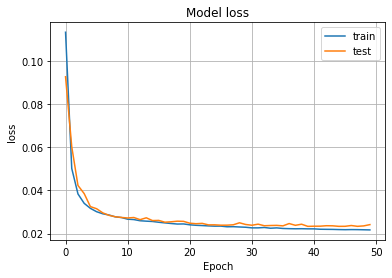

Test RMSE: 29.289
Test MAE: 20.801
Test MAPE: 0.036


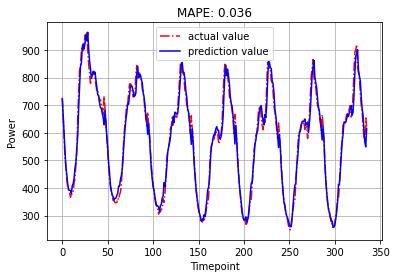

In [3]:
'''
{['n_neurons': 135, 'n_hidden': 5, 'learning_rate': 0.01, 'batch_size': 145, 'score':-0.019615494832396507]
 ['n_neurons': 228, 'n_hidden': 3, 'learning_rate': 0.001, 'batch_size': 152,'score':-0.01886052545160055']}
'''
from math import sqrt
# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(251, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(251,  return_sequences=False, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mape'], optimizer=optimizer)
# fit network
checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_best_NewData.h5', 
                                                save_best_only=True)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, 
                    verbose=2, shuffle=False, callbacks=[checkpoint_cb])
print(history.history.keys())
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Model loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('loss')
pyplot.grid(True)
pyplot.legend()
pyplot.show()


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

# plot actual and preidict value
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='r', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='b', label='prediction value')
pyplot.title('MAPE: %.3f' % mape)
pyplot.xlabel('Timepoint')
pyplot.ylabel('Power')
pyplot.grid(True)
pyplot.legend()
pyplot.show()

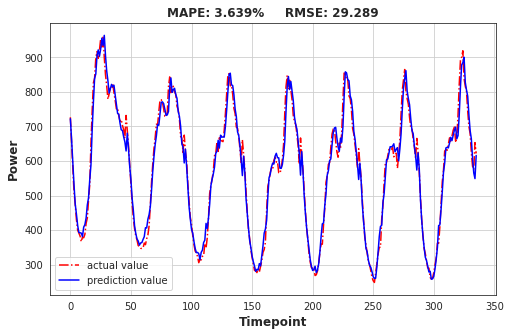

In [12]:

import seaborn as sns
sns.set_style('white')
font1 = {'weight':'bold',
        'size':12,}
pyplot.figure(figsize=(8, 5))
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='red', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='blue', label='prediction value')
pyplot.title('MAPE: %.3f%%' % mape + '     ' + 'RMSE: %.3f' % rmse, font1)
pyplot.xlabel('Timepoint', font1)
pyplot.ylabel('Power', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('LSTM for clean aggregation households')
pyplot.show()

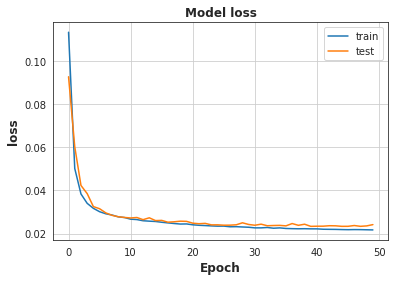

In [14]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Model loss', font1)
pyplot.xlabel('Epoch', font1)
pyplot.ylabel('loss', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('model loss of LSTM for clean aggregation households')
pyplot.show()